In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

In [21]:
dfTweets = pd.read_csv('../data/preprocessedTweets.csv')

dfTweets.drop(['Unnamed: 0'], axis=1, inplace=True)

In [22]:
dfTweets.columns

Index(['Date', 'TweetURL', 'User', 'Source', 'Location', 'Tweet',
       'Likes_Count', 'Retweet_Count', 'Quote_Count', 'Reply_Count',
       'compoundVader', 'compoundTextBlob', 'Tweet_NLTK', 'Sentiment'],
      dtype='object')

In [23]:
dfMarket = pd.read_csv('../data/price_mining.csv')

In [24]:
dfTweets.to_csv('../data/preprocessedTweets.csv')

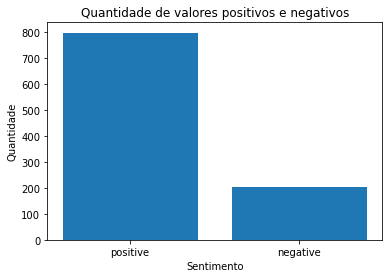

In [25]:
# Contar a quantidade de valores positivos e negativos
count = dfTweets["Sentiment"].value_counts()

# Criar o gráfico de barras
plt.bar(count.index, count.values)

# Adicionar títulos e rótulos dos eixos
plt.title("Quantidade de valores positivos e negativos")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")

# Mostrar o gráfico
plt.show()

#### Bullish Ratio analysis

Tweet’s bullish ratio is known as the number of positive tweets over a number of negative tweets.

A bullish ratio greater than one indicates audiences’ belief that the cryptocurrency’s return will increase. Otherwise, a value lower than one shows greater negativity towards the cryptocurrency and the market will be pulled back in near future

In [26]:
bullishRatio = count[0] / count[1]
print("Razão de tweets positivos para negativos: ", bullishRatio)

Razão de tweets positivos para negativos:  3.9504950495049505


#### Cast tweets date to datetime type

In [27]:
dfTweets["Date"] = pd.to_datetime(dfTweets["Date"])

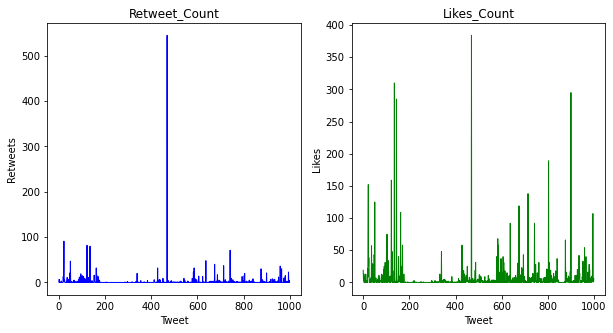

In [29]:
# Definir tamanho da figura
plt.figure(figsize=(10, 5))

# Primeiro gráfico para Retweet_Count
plt.subplot(1, 2, 1)
plt.plot(dfTweets["Retweet_Count"], color="blue", linewidth=1)
plt.title("Retweet_Count")
plt.xlabel("Tweet")
plt.ylabel("Retweets")

# Segundo gráfico para Likes_Count
plt.subplot(1, 2, 2)
plt.plot(dfTweets["Likes_Count"], color="green", linewidth=1)
plt.title("Likes_Count")
plt.xlabel("Tweet")
plt.ylabel("Likes")

# Exibir os gráficos
plt.show()


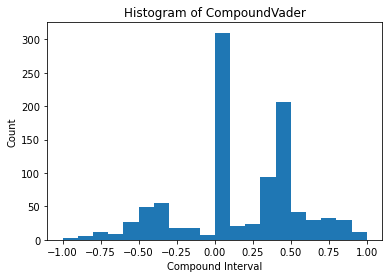

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Criando os intervalos de 0,1 de -1 a 1
bins = np.arange(-1, 1.1, 0.1)

# Plotando o gráfico de barras
plt.hist(dfTweets['compoundVader'], bins=bins)
plt.xlabel('Compound Interval')
plt.ylabel('Count')
plt.title('Histogram of CompoundVader')
plt.show()


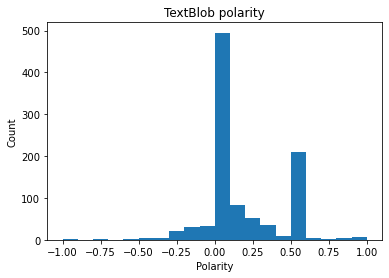

In [31]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# aplicando expressão regular para extrair o valor da polaridade
dfTweets['polarity'] = dfTweets['compoundTextBlob'].apply(lambda x: float(re.search(r'polarity=(-?\d+\.?\d*)', x).group(1)))

# criando um histograma com a polaridade
fig, ax = plt.subplots()
ax.set_title('TextBlob polarity')
ax.hist(dfTweets['polarity'], bins=20)
ax.set_xlabel('Polarity')
ax.set_ylabel('Count')
plt.show()


#### Check compound variance over time

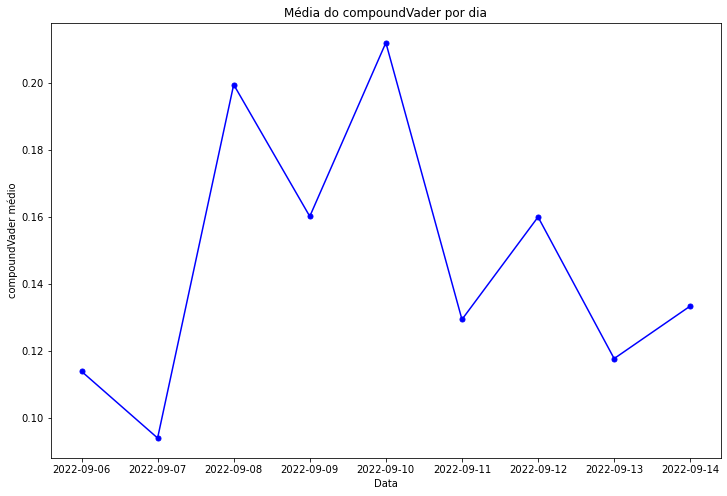

In [32]:
dfTweets['Date'] = pd.to_datetime(dfTweets['Date']).dt.date

df_daily = dfTweets.groupby('Date')['compoundVader'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_daily['Date'], df_daily['compoundVader'], color='blue', marker='o', markersize=5)

ax.set_xlabel('Data')
ax.set_ylabel('compoundVader médio')
ax.set_title('Média do compoundVader por dia')
plt.show()


#### Check price variance over time

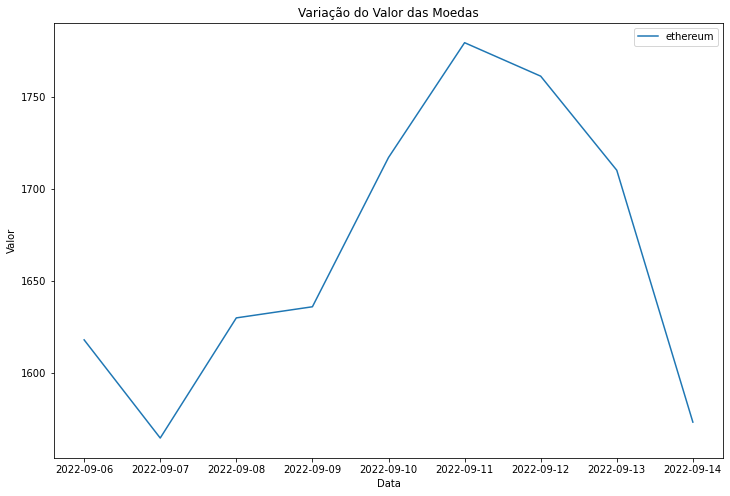

In [33]:
dfMarket = dfMarket[(dfMarket['datetime'] >= '2022-09-06') & (dfMarket['datetime'] <= '2022-09-14')]


df_daily = dfMarket.groupby(['Date', 'currency_name'])['Value'].agg('mean').reset_index()


fig, ax = plt.subplots(figsize=(12, 8))

for currency in df_daily['currency_name'].unique():
    df_currency = df_daily[df_daily['currency_name'] == currency]
    ax.plot(df_currency['Date'], df_currency['Value'], label=currency)

ax.set_xlabel('Data')
ax.set_ylabel('Valor')
ax.set_title('Variação do Valor das Moedas')
ax.legend()
plt.show()


#### Gráfico comparativo entre Sentimento dos tweets e valor da Criptomoeda

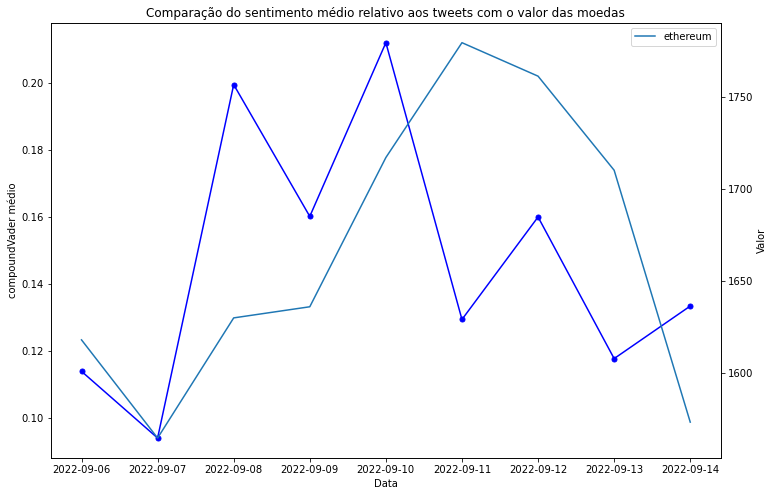

In [34]:
dfTweets['Date'] = pd.to_datetime(dfTweets['Date'])
dfMarket['Date'] = pd.to_datetime(dfMarket['Date'])



df_tweets_daily = dfTweets.groupby(dfTweets['Date'].dt.date)['compoundVader'].mean().reset_index()
df_market_daily = dfMarket.groupby(['Date', 'currency_name'])['Value'].mean().reset_index()



fig, ax1 = plt.subplots(figsize=(12,8))
# plotar o gráfico para a média do compoundVader
ax1.plot(df_tweets_daily['Date'], df_tweets_daily['compoundVader'], color='blue', marker='o', markersize=5)
ax1.set_xlabel('Data')
ax1.set_ylabel('compoundVader médio')
ax1.set_title('Comparação do sentimento médio relativo aos tweets com o valor das moedas')

# criar um segundo eixo y para o valor médio das moedas
ax2 = ax1.twinx()

# plotar o gráfico para o valor médio das moedas
for currency in df_market_daily['currency_name'].unique():
    df_currency = df_market_daily[df_market_daily['currency_name'] == currency]
    ax2.plot(df_currency['Date'], df_currency['Value'], label=currency)
    
ax2.set_ylabel('Valor')
ax2.legend()
plt.show()


#### Calculate correlation between both

In [35]:
# Agrupa os dados da criptomoeda por dia e calcula a média diária do valor
dfMarket_daily = dfMarket.groupby('Date')['Value'].mean().reset_index()

# Agrupa os dados dos tweets por dia e calcula a contagem diária e a média diária do compoundVader
dfTweets_daily = dfTweets.groupby('Date').agg({'Tweet': 'count', 'compoundVader': 'mean'}).reset_index()
dfTweets_daily = dfTweets_daily.rename(columns={'Tweet': 'Tweets'})

# Junta os dados da criptomoeda e dos tweets em uma só tabela, usando a coluna 'Date' como chave
df_merged = pd.merge(dfMarket_daily, dfTweets_daily, on='Date')

# Calcula a correlação entre o valor diário da criptomoeda e a média diária do compoundVader
corr = df_merged['Value'].corr(df_merged['compoundVader'])

print('Correlação: {:.2f}'.format(corr))

Correlação: 0.29


## Fazer REGRESSAO LINEAR PARA PERCEBER SE O 0.3 É SIGNIFICATIVO

ver tbm uma previsao cm a reg lin

#### Calculate cross correlation

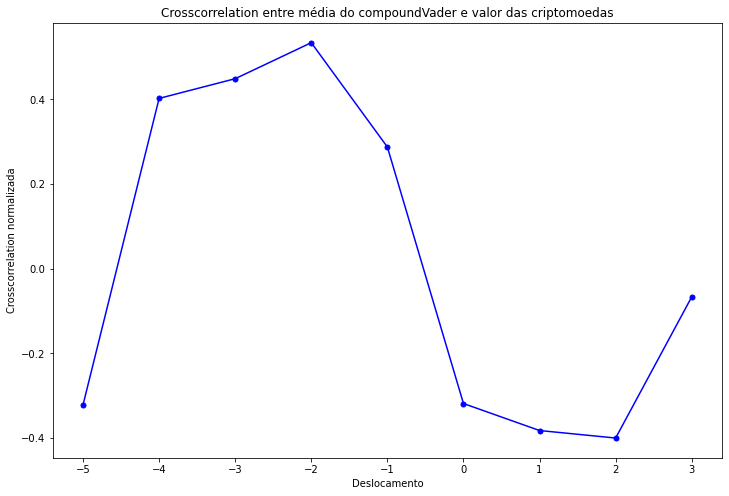

In [36]:
import numpy as np

# extrair valores relevantes do dataset de tweets e de criptomoedas
tweets_daily = dfTweets.groupby('Date')['compoundVader'].mean().values

crypto_daily = dfMarket.groupby('Date')['Value'].mean().values

# calcular a crosscorrelation e normalizar o resultado
crosscorr = np.correlate(tweets_daily - tweets_daily.mean(), crypto_daily - crypto_daily.mean(), mode='same') / np.sqrt(np.sum((tweets_daily - tweets_daily.mean())**2) * np.sum((crypto_daily - crypto_daily.mean())**2))

# plot da crosscorrelation
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(np.arange(-len(crypto_daily) // 2, len(crypto_daily) // 2), crosscorr, color='blue', marker='o', markersize=5)

ax.set_xlabel('Deslocamento')
ax.set_ylabel('Crosscorrelation normalizada')
ax.set_title('Crosscorrelation entre média do compoundVader e valor das criptomoedas')
plt.show()


#### Granger Causality Tests

In [47]:
# dfTweets['compoundVader'].isnull().values.any()

# print(np.isinf(dfTweets['compoundVader']).any()) 

False


In [57]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests, array_like

# Extrair as séries temporais de interesse
x = dfMarket['Value']
y = dfTweets['compoundVader']

x2 = array_like(pd.concat([x, y], axis=1), "x", ndim=2)
print(np.isfinite(x2).all())

# Executar o teste de causalidade de Granger
results = grangercausalitytests(pd.concat([x, y], axis=0), maxlag=10)   #TODO: tinha aqui axis = 1, mas não funcionou

# Imprimir os resultados
for lag in results.keys():
    print(f"Lag: {lag}")
    print(f"  F-statistic: {results[lag][0]['ssr_ftest'][0]}")
    print(f"  p-value: {results[lag][0]['ssr_ftest'][1]}")
    print(f"  df_denom: {results[lag][0]['ssr_ftest'][2]}")
    print(f"  ssr_chi2test: {results[lag][0]['ssr_chi2test'][0]}")
    print(f"  p-value: {results[lag][0]['ssr_chi2test'][1]}")
    print(f"  df: {results[lag][0]['ssr_chi2test'][2]}")

False

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=1006, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1


ValueError: wrong shape for coefs

In [38]:
# np.all(np.isfinite(x))

#### Autoencoder

In [40]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Agregar os dados por dia
df_daily = dfMarket.groupby(['Date', 'currency_name'])['Value'].mean().reset_index()

# Transformar os dados em uma matriz numpy
X = df_daily.pivot(index='Date', columns='currency_name', values='Value').values

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir a arquitetura do autoencoder
input_dim = X.shape[1]
hidden_dim = 10

input_layer = Input(shape=(input_dim,))
hidden_layer = Dense(hidden_dim, activation='relu')(input_layer)
output_layer = Dense(input_dim, activation='linear')(hidden_layer)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compilar o modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o modelo
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32)

# Codificar os dados
encoder = Model(inputs=input_layer, outputs=hidden_layer)
X_encoded = encoder.predict(X_scaled)

# Imprimir a forma dos dados codificados
print(X_encoded.shape)

2023-05-11 15:51:30.391832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: josejoao-S540
2023-05-11 15:51:30.391861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: josejoao-S540
2023-05-11 15:51:30.391953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-05-11 15:51:30.391992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.182.3


Epoch 1/100
1/1 [==============================] - 0s 480ms/step - loss: 0.9848
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.9746
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.9644
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.9543
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.9442
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.9343
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.9243
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.9144
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.9046
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8949
Epoch 11/100
1/1 [==============================] - 0s 7ms/step - loss: 0.8852
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8755
Epoch 13/100
1/1 [==============================] - 0s 5ms/

----
#### Datas presentes no dataset

In [41]:
df1 = pd.read_csv('../data/bullishTweets.csv')
df1['Date'] = pd.to_datetime(dfTweets['Date']).dt.date
df1["Date"].unique()

array([datetime.date(2022, 9, 9), datetime.date(2022, 9, 11),
       datetime.date(2022, 9, 13), datetime.date(2022, 9, 12),
       datetime.date(2022, 9, 14), datetime.date(2022, 9, 10),
       datetime.date(2022, 9, 7), datetime.date(2022, 9, 8),
       datetime.date(2022, 9, 6)], dtype=object)

### TODO:
- Aplicar sliding window de 1 dia no grafico que compara os dois
- Utilizar linear regression para previsao de preços
- Aplicar linear regression para verificar a correlacao se é significante ou nao 